# Importing libraries and functions

Importing required libraries

In [13]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import Input, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Softmax, Multiply, Lambda
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
from matplotlib import pyplot as plt
import os
import sys



In [14]:
def make_dir(path): # Function to make adirectory to save files in
    cwd = os.getcwd()
    abs_path = cwd + path


    if not os.path.exists(abs_path):
        try: 
            os.makedirs(abs_path)
            print(abs_path)
        except OSError:return 0
        else: return 1
    else: return 2

In [15]:
# Declaring Variables
num_epochs = 200000
load_adam_maxval = 'SavedModels/IndVal/OptiStudies/model_Adam'
load_sgdnm_indval = 'SavedModels/IndVal/OptiStudies/model_SGD_NM'





# Filepaths for saving Model Checkpoints:
save_post_dir = 'PostProc/GridSearchCV'

In [16]:
# Reading data from .csv file
data_dat = pd.read_csv (r'data.csv')
pred_dat = pd.read_csv (r'test.csv')

In [17]:
# Extracting data into numpy arrays from pandas DataFrames

# Training data
X = pd.DataFrame(data_dat, columns = ['LD'])
X = X.to_numpy()

X_n = pd.DataFrame(data_dat, columns = ['XL'])
X_n = X_n.to_numpy()


y = pd.DataFrame(data_dat, columns = ['Ma'])
y = y.to_numpy()

# Prediction data
X_pred = pd.DataFrame(pred_dat, columns = ['LD'])
X_pred = X_pred.to_numpy()
X_pred_ns = X_pred

X_n_pred = pd.DataFrame(pred_dat, columns = ['XL'])
X_n_pred = X_n_pred.to_numpy()

y_pred = pd.DataFrame(pred_dat, columns = ['Ma'])
y_pred = y_pred.to_numpy()



In [18]:
# Returns normalised valeus of Mach Number and Maximum Mach Number per L/D ratio as two arrays

def get_norm_y(y,c): 
    num = int(y.shape[0] / c)
    max_val = np.zeros(c*num)
    y_norm = np.zeros([num*c])
    for i in range(num):
        max_val[i*c:(i+1)*c] = max(y[i*c:(i+1)*c])
        for j in range(c):
            y_norm[i*c + j] = y[i*c+j]/max_val[i]
    return y_norm, max_val
    
y_norm, max_y = get_norm_y(y, 201)
y_pred_norm, y_pred_max = get_norm_y(y_pred, 201)

# Returns Input set fro training the Max Mach Numbers

def get_x(x,c):
    x_n = np.zeros(x.shape[0])
    
    for i in range(x.shape[0]):
        x_n[i] = x[i]
    
    return x_n

X_max = get_x(X,201)
X_pred_max = get_x(X_pred, 201)

X= np.hstack((X_n,X))
X_pred = np.hstack((X_n_pred,X_pred))

In [19]:
y_comb = np.zeros([y_norm.shape[0],2])
for i in range(y_comb.shape[0]):
    y_comb[i,0]=y_norm[i]
    y_comb[i,1]=max_y[i]
print(y_comb)

[[0.05378558 3.0035    ]
 [0.05246379 3.0035    ]
 [0.05142334 3.0035    ]
 ...
 [0.05235226 1.54621   ]
 [0.05012485 1.54621   ]
 [0.0479101  1.54621   ]]


In [20]:
y_comb.shape

(603, 2)

In [21]:
print(X)

[[0.00e+00 7.00e+00]
 [5.00e-03 7.00e+00]
 [1.00e-02 7.00e+00]
 ...
 [9.90e-01 5.00e+00]
 [9.95e-01 5.00e+00]
 [1.00e+00 5.00e+00]]


In [128]:
MaxVal_archi = [20, 20, 20, 1]
IndVal_archi = [20, 20, 20, 20, 20, 1]

def get_LD(x):
    x_new = x[0,1:]
    return x_new[:,np.newaxis]


def build_model(MaxVal_archi, IndVal_archi):

    Input_layer = Input(shape=[2,], name='Input')

    '''MaxVal_input = Lambda(get_LD, name='MaxVal_input', output_shape=(None, 1))(Input_layer)
    '''
    """    MaxVal_layer = []
    for i,node in enumerate(MaxVal_archi):
        if i==0:
            MaxVal_layer.append(Dense(node, name='MaxVal_layer%d' %(i+1), activation='relu')(MaxVal_input))
        elif i==len(MaxVal_archi)-1:
            MaxVal_layer.append(Dense(1, name='MaxVal_Final_layer', activation='relu')(MaxVal_layer[i-1])) 
        else:
            MaxVal_layer.append(Dense(node, name='MaxVal_layer%d' %(i+1), activation='relu')(MaxVal_layer[i-1]))
    """
    IndVal_layer = []
    for i, node in enumerate(IndVal_archi):
        if i==0:
            IndVal_layer.append(Dense(node, name='IndVal_layer%d' %(i+1), activation='relu')(Input_layer))
        elif i==len(IndVal_archi)-1:
            IndVal_layer.append(Dense(1, name='IndVal_Final_layer', activation='relu')(IndVal_layer[i-1])) 
        else:
            IndVal_layer.append(Dense(node, name='IndVal_layer%d' %(i+1), activation='relu')(IndVal_layer[i-1]))

            
#     Multiplication_layer = Multiply(name='Multiplication_layer')([IndVal_layer[len(IndVal_archi)-1], MaxVal_layer[len(MaxVal_archi)-1]])
    
#     PreFinal_layer1 = Dense(20, name='PreFinal_layer1', activation='relu')(Multiplication_layer)
#     PreFinal_layer2 = Dense(20, name='PreFinal_layer2', activation='relu')(PreFinal_layer1)
#     PreFinal_layer3 = Dense(20, name='PreFinal_layer3', activation='relu')(PreFinal_layer2)
    
#     Final_layer = Dense(1, name='Final_layer', activation='linear')(PreFinal_layer3)
    
    model = Model(inputs= [Input_layer], outputs= IndVal_layer[len(IndVal_archi)-1])
    return model

model = build_model(MaxVal_archi,IndVal_archi)

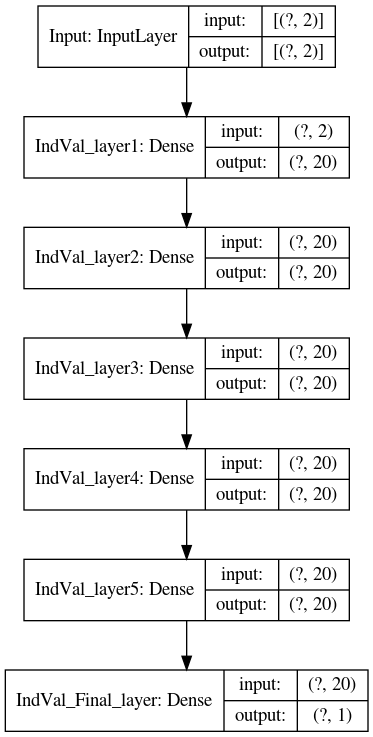

In [129]:
keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)
# print(model.summary())

In [130]:
print(model.summary())

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 2)]               0         
_________________________________________________________________
IndVal_layer1 (Dense)        (None, 20)                60        
_________________________________________________________________
IndVal_layer2 (Dense)        (None, 20)                420       
_________________________________________________________________
IndVal_layer3 (Dense)        (None, 20)                420       
_________________________________________________________________
IndVal_layer4 (Dense)        (None, 20)                420       
_________________________________________________________________
IndVal_layer5 (Dense)        (None, 20)                420       
_________________________________________________________________
IndVal_Final_layer (Dense)   (None, 1)                 21  

In [113]:
model.compile(loss='mse', optimizer='RMSprop', metrics=['mse'])


In [131]:
print(y_norm)

[0.05378558 0.05246379 0.05142334 0.05078242 0.04949858 0.04441918
 0.03775695 0.02608004 0.01875106 0.0268303  0.0460879  0.07159913
 0.10153188 0.13601265 0.16721225 0.19557749 0.22025404 0.24268886
 0.27487931 0.31143466 0.34778092 0.3841152  0.41247545 0.43953721
 0.4643982  0.48923922 0.51239554 0.53578492 0.56060263 0.58401199
 0.59942401 0.61506909 0.63103712 0.64918595 0.67205261 0.6927418
 0.70991177 0.72428833 0.73543865 0.74520726 0.75383386 0.76259364
 0.77143666 0.78179124 0.79281505 0.80347927 0.81408357 0.82256035
 0.83070085 0.83620443 0.8415149  0.8451107  0.84912602 0.85795239
 0.86691859 0.87660063 0.88495755 0.8888297  0.89214916 0.89418345
 0.89812552 0.90505743 0.91283836 0.92160146 0.92768104 0.93146662
 0.93581155 0.94050941 0.9467388  0.95365407 0.95745963 0.96035292
 0.96295322 0.96551024 0.96607291 0.96647245 0.96237723 0.95883802
 0.96177793 0.96535708 0.9724255  0.9783386  0.9803962  0.98206426
 0.98285001 0.98336274 0.98344598 0.98396204 0.98498751 0.98632

In [114]:
early_stopping_callback = EarlyStopping(monitor='loss', 
                                        patience=20,
                                        min_delta= 1e-3,
                                        restore_best_weights=True,
                                        mode='auto')

In [115]:
##### Using sklearn to split the data into train and test sets with shuffling ####
X_train, X_test, y_train_comb, y_test_comb = train_test_split(X, y_norm, test_size=0.2, random_state=42, shuffle=True)


# y_norm_train = y_train_comb[:,0]
# y_max_train = y_train_comb[:,1]
# y_norm_test = y_test_comb[:,0]
# y_max_test = y_test_comb[:,1]

In [118]:
history = model.fit(X_train,
                    y_train_comb,
                    batch_size = 2,
                    epochs=10,
                    verbose=True,
                    validation_data=(X_test,y_test_comb))

model.save('temp_models/SiameseModel')

Train on 482 samples, validate on 121 samples
Epoch 1/10
482/482 [==============================] - 0s 777us/sample - loss: 0.5187 - mse: 0.5187 - val_loss: 0.4935 - val_mse: 0.4935
Epoch 2/10
482/482 [==============================] - 0s 754us/sample - loss: 0.5187 - mse: 0.5187 - val_loss: 0.4935 - val_mse: 0.4935
Epoch 3/10
482/482 [==============================] - 0s 990us/sample - loss: 0.5187 - mse: 0.5187 - val_loss: 0.4935 - val_mse: 0.4935
Epoch 4/10
482/482 [==============================] - 0s 831us/sample - loss: 0.5187 - mse: 0.5187 - val_loss: 0.4935 - val_mse: 0.4935
Epoch 5/10
482/482 [==============================] - 0s 787us/sample - loss: 0.5187 - mse: 0.5187 - val_loss: 0.4935 - val_mse: 0.4935
Epoch 6/10
482/482 [==============================] - 0s 781us/sample - loss: 0.5187 - mse: 0.5187 - val_loss: 0.4935 - val_mse: 0.4935
Epoch 7/10
482/482 [==============================] - 0s 793us/sample - loss: 0.5187 - mse: 0.5187 - val_loss: 0.4935 - val_mse: 0.4935
Ep

In [119]:
pred = model.predict(X_pred)

In [121]:
print(pred)

[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]


In [81]:
for i in range(int(pred[1].shape[0]/201)):
    print(X_pred_max[i*201])

6.0
6.5
7.5
8.0
8.5
10.0
5.0
4.0
4.5
3.0
9.0


In [82]:
for i in range(int(pred[1].shape[0]/201)):
    
    print(abs(pred[1][i*201]-y_pred_max[i*201])/y_pred_max[i*201])

[0.330245]
[0.4252388]
[0.01237187]
[0.03497924]
[0.06440692]
[0.01877775]
[0.00017779]
[1.]
[0.95877826]
[0.64949286]
[1.3829593e-05]


In [48]:
print(pred[1].shape[0]/201)

11.0


ValueError: x and y must have same first dimension, but have shapes (201, 1) and (2, 2211, 1)

<Figure size 432x288 with 0 Axes>

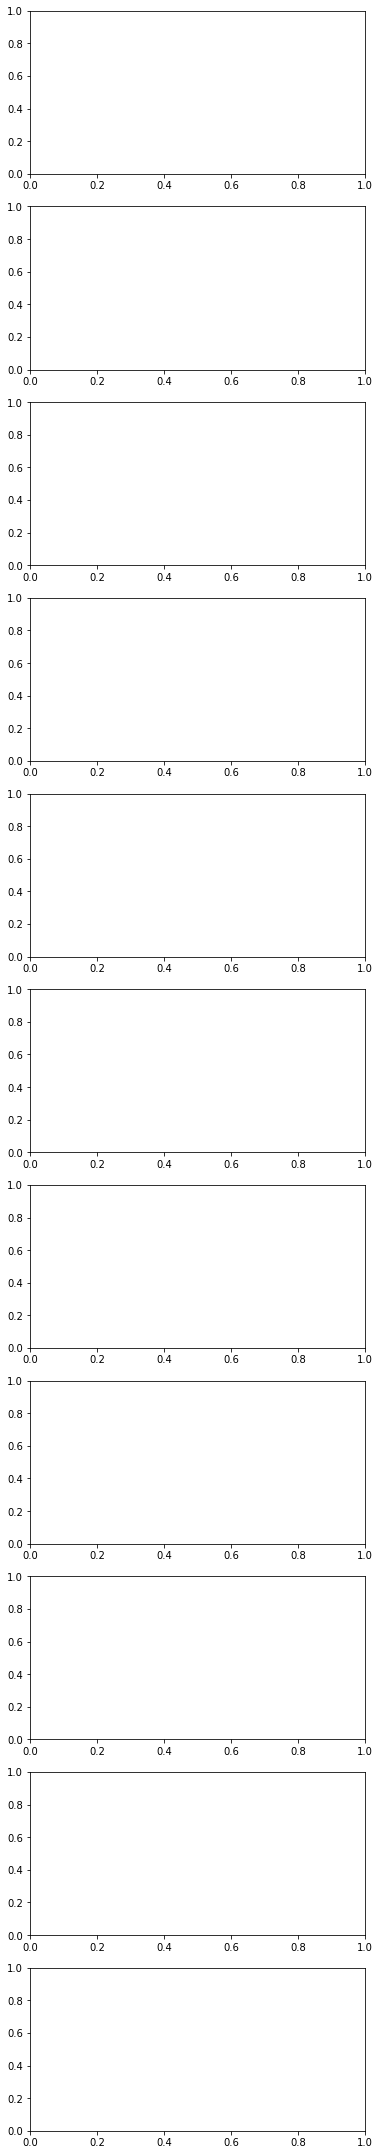

In [38]:
nrows=int(X_pred.shape[0]/201)
fig3 = plt.figure()
fig, axes = plt.subplots(nrows)
fig.set_size_inches(6,39)
for j in range(nrows):
    axes[j].plot(X_n_pred[:201],
                  pred[j*201:(j+1)*201],
                  'r',
                  label='Prediction')
    axes[j].plot(X_n_pred[j*201:(j+1)*201], y_pred[j*201:(j+1)*201], 'g', label='Actual')
    axes[j].set(xlabel="Normalised x-coordinate", ylabel="Mach Number")
    axes[j].set_title('L/D Ratio = %.1f' %(X_pred_max[j]), fontsize=11)
    axes[j].legend(loc="upper right")
    axes[j].set_xlim((0,1))
    axes[j].set_ylim((0,5))
    axes[j].set_aspect(0.2)

fig = plt.gcf()
plt.tight_layout(pad=0.25, h_pad=1.25, w_pad=0.25, rect=None)
# plt.savefig(save_post_dir + 'cumilative_ind_%s_predictions.png' %(opti_name), dpi=500)
plt.show(fig3)
plt.close(fig3)

In [ ]:
print(np.zeros([1,2]))

In [ ]:
print(X_pred.shape)